In [12]:
import pandas as pd
import numpy as np
import random as rd
import datetime as dt
import math
import sklearn.preprocessing as p
import matplotlib.pyplot as plt

In [17]:
def checkIfNone(variable,variableName):
    if variable is None:
        raise ValueError(f'{variableName} param is required.')
    return None

def checkType(variable,variableName,varType):
    if type(variable) != varType:
        raise TypeError(f'{variableName} param must be of type {varType}')
    return None

def runChecks(variable,variableName,varType):
    checkIfNone(variable,variableName)
    checkType(variable,variableName,varType)
    return None

def dictShapeCheck(dictToCheck,blueprint):
    for d,v in dictToCheck.items():
        try:
            if type(blueprint[d]) == dict:
                dictShapeCheck(v,blueprint[d])
            elif type(v) != blueprint[d]:
                raise TypeError(f'Value of {d} must be of type {blueprint[d]}')
        except KeyError:
            raise KeyError(f'{d} is not in the blueprint keys')
    return None

def listToDict(listOfKeys,Value):
    finalDict = dict()
    for k in listOfKeys:
        finalDict[k] = Value
    return finalDict

def saturationGen(alpha,gamma):
    def f(x):
        return x**alpha/(x**alpha+gamma**alpha)
    return f

def geometricAdStock(theta):
    def f(actual,previous):
        return actual + theta*previous
    return f

def weibullAdStock(shape,scale,type='pdf'):
    def fPDF(t):
        return scale*shape*(scale*t)**(shape-1)*e**((-1)*(scale*t)**shape)

    def fCDF(t):
        return 1-e**((-1)*(scale*t)**shape)

    def f(actual,previous,t):
        if type=='pdf':
            return actual+fPDF(t)*previous
        if type=='cdf':
            return actual+fCDF(t)*previous

    if type not in ['cdf','pdf']:
        raise ValueError('type param must be "pdf" or "cdf"')
    return f

def sinFunctionGen(omega,phi,A=1):
    return lambda x: A*math.sin(omega*x+phi)

def biWaveGenFunctionGen(omega1,omega2,phi,A=1):
    def f(x):
        if x<=math.pi/2:
            return A*math.sin(omega1*x+phi)
        else:
            return A*math.sin(omega2*x+phi)
    return f

def phiBaselineCalculator(base,omega,axisValue):
    return math.asin(base)-omega*axisValue
    

def scaleToRadian(initialTime,finalTime,radianStart,radianEnd):
    m = (radianEnd-radianStart)/(finalTime-initialTime)
    b = radianStart-m*initialTime
    return lambda x: m*x+b

def siMMMDataGenerator(
    variablesName: list = None,
    variablesRanges: dict = None,
    dateStartStop: list = None,
    dateFreq: str = 'weekly',
    adStockType: str = 'geometric',
    weibullType: str = 'pdf',
    adStockParams: dict = None,
    saturationParams: dict = None,
    randomSeed: int = 100,
    campaignData: dict = None, #Units of params must be the same of specified in dateFreq
    pathToCSV: str = None,
    ):
    
    runChecks(variablesName,'variablesName',list)
    runChecks(variablesRanges,'variablesRanges',dict)
    dictShapeCheck(variablesRanges,listToDict(variablesName,{'min':int,'max':int}))
    runChecks(dateStartStop,'dateStartStop',list)
    runChecks(adStockParams,'adStockParams',dict)
    if adStockType == 'geometric':
        dictShapeCheck(adStockParams,listToDict(variablesName,{'theta':float}))
    elif adStockType == 'weibull':
        dictShapeCheck(adStockParams,listToDict(variablesName,{'shape':float,'scale':float}))
    runChecks(saturationParams,'saturationParams',dict)
    dictShapeCheck(saturationParams,listToDict(variablesName,{'gamma':float,'alpha':float}))
    runChecks(campaignData,'campaignData',dict)
    dictShapeCheck(campaignData,listToDict(variablesName,{'startTime':list,'duration':{'upHill':list,'downHill':list},'baseValue':float}))
    

    #We define the start date and end date variables
    startDate = dt.datetime.strptime(dateStartStop[0],'%Y-%m-%d')
    endDate = dt.datetime.strptime(dateStartStop[1],'%Y-%m-%d')
    totalDelta = endDate-startDate
    nOf = {
        'days': totalDelta.days,
        'weeks': int(round(totalDelta.days/7+0.4)) #+0.4 to do the same as math.ceil()
    }
    deltaOf = {
        'days': dt.timedelta(days=1),
        'weeks': dt.timedelta(days=7),
    }
    lyMap = {
        'daily':'days',
        'weekly':'weeks'
    }
    #First we generate the time series
    time = range(nOf[lyMap[dateFreq]])
    timeDate = list()
    for i,_ in enumerate(time):
        if i==0:
            currentDate = startDate
        else:
            currentDate = prevDate + deltaOf[lyMap[dateFreq]]
        timeDate.append(currentDate)
        prevDate = currentDate
    
    #First we generate the distribution of values in time
    timeDistributions = dict()
    for channel,timeData in campaignData.items():
        timeDistributions[channel] = list()
        index = 0
        end1=-1
        end2=-1 #Initial value that wont be found
        baseline = campaignData[channel]['baseValue']
        phiForBaseValue = phiBaselineCalculator(baseline,1,0) 
        for i,t in enumerate(time):
            #print(index,i,t)
            if index==0:
                start = campaignData[channel]['startTime'][index]
            else:
                start = end2 + campaignData[channel]['startTime'][index]
            if t == start:
                dur1 = campaignData[channel]['duration']['upHill'][index]
                dur2 = campaignData[channel]['duration']['downHill'][index]
                end1 = start+dur1
                end2 = end1+dur2
                #Escalamos
                scaler1 = scaleToRadian(start,end1,0,math.pi*0.5)
                scaler2 = scaleToRadian(end1,end2,0.5*math.pi,math.pi)
            elif t==end2:
                if index < len(campaignData[channel]['startTime'])-1:
                    index+=1
                else:
                    pass
            if t>=start and t<=end1:
                budgetPerc = sinFunctionGen(1,phiForBaseValue,1)(scaler1(t))
            elif t>end1 and t<=end2:
                budgetPerc = sinFunctionGen(1,phiForBaseValue,1)(scaler2(t))
            else:
                budgetPerc = baseline
            timeDistributions[channel].append(budgetPerc)
    #Once we have the time distribution we calculate the adStock for each channel
    #This could be done inside the previous loop, but this is cleaner and the amount of data wont be large enough to
    #turn time complexity in a problem
    adStockedMedia = dict()
    if adStockType == 'weibull':
        timePercenWeibullMatrix = list()
        #The first row of the matrix must be the same as the time variable in percentage
        for i,t1 in enumerate(time):
            row=list()
            for j,t2 in enumerate(time):
                if j<i:
                    row.append(0) #Para hacer que la matriz sea cuadrada, aunque habrá que saltarse las filas para leer de diagonalmente la matriz
                else:
                    row.append((t2-t1)/t1) #Esta división hará que cada valor represente cuantas veces es la distancia temporal con respecto al instante
                    #Haciendo que cada instante inicial sea siempre cero
            timePercenWeibullMatriz.append(row)
            
    for channel in adStockParams.keys():
        adStockedMedia[channel] = list()
        if adStockType == 'geometric':
            adStockFunction = geometricAdStock(adStockParams[channel]['theta'])
        elif adStockType == 'weibull':
            adStockFunction = weibullAdStock(adStockParams[channel]['shape'],adStockParams[channel]['scale'],weibullType)
        # Apply adStock to each value in time
        for i,budgetPer in enumerate(timeDistributions[channel]):
            if i==0:
                previousValue=0
            actualValue = budgetPer
            if adStockType == 'geometric':
                adStocked = adStockFunction(actualValue,previousValue)
            if adStockType == 'weibull':
                '''
                Aunque weibull es continua para todo R>0, la pendiente de la función se vuelve aproximadamente constante para x=3, por lo que
                hay que transformar los valores del tiempo (que será el x de la función de Weibull) a estos rangos.

                Por otro lado, hay que tener en cuenta que esta función de Weibull se utiliza para modelizar el lag o delay que existe entre que se
                aplica el gasto en el canal de marketing con el tiempo, por lo que cada valor tendrá su propio lag.

                En otras palabras cada punto representa el punto inicial de la función de Weibull y los instantes posteriores tendrán el efecto que
                que indique Weibull, más el efecto de los puntos anteriores, cada uno según lo que le haya supuesto Weibull en dicho punto respecto
                al que se mide.

                Para obtener el instante de tiempo en porcentaje que representa cada punto respecto a los anteriores utilizamos la matriz
                '''
                adStocked = 0
                for j,row in enumerate(timePercenWeibullMatrix):
                    if j<=i:
                        adStocked+=adStockFunction(row[i])
                    else:
                        break
                pass
            adStockedMedia[channel].append(adStocked)
            previousValue=actualValue
    #Once we calculated adStocke, we need to calculate saturation
    saturatedMedia = dict()
    for channel in saturationParams.keys():
        saturatedMedia[channel] = list()
        saturationFunction = saturationGen(saturationParams[channel]['alpha'],saturationParams[channel]['gamma'])
        for adStocked in adStockedMedia[channel]:
            saturatedMedia[channel].append(saturationFunction(adStocked))

    #We get the revenue
    revenue = list()
    for t in time:
        total=0
        for channel in saturatedMedia.keys():
            total+=saturatedMedia[channel][i]
        revenue.append(total)

    finalDF = pd.DataFrame.from_dict(saturatedMedia)
    finalDF['revenue'] = revenue
    finalDF['DATE'] = timeDate
    finalDF.to_csv(pathToCSV)
    return None

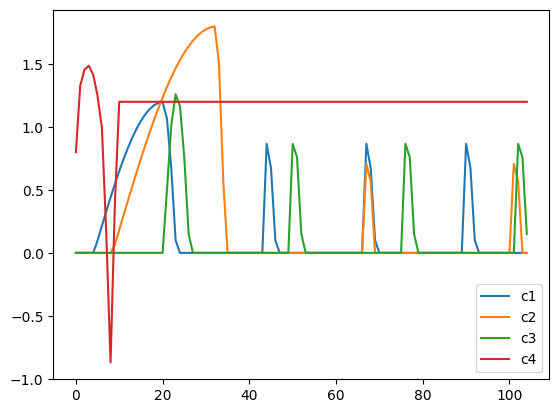

In [18]:
siMMMDataGenerator(
    ['c1','c2','c3','c4'],
    {
        'c1':{'min':0,'max':100},
        'c2':{'min':0,'max':100},
        'c3':{'min':0,'max':100},
        'c4':{'min':0,'max':100},
    },
    ['2018-01-01','2020-01-01'],
    'weekly',
    'geometric',
    'pdf',
    {
        'c1':{'theta':0.2},
        'c2':{'theta':0.8},
        'c3':{'theta':0.3},
        'c4':{'theta':0.5},
    },
    {
        'c1':{'alpha':2.2,'gamma':0.6},
        'c2':{'alpha':2.2,'gamma':0.3},
        'c3':{'alpha':4.0,'gamma':1.1},
        'c4':{'alpha':1.6,'gamma':1.6},
    },
    100,
    {
        'c1':{
            'startTime':[4,4,4],
            'duration':{'upHill':[16,16,16],'downHill':[3,3,3]},
            'baseValue':0.0
        },
        'c2':{
            'startTime':[8,8],
            'duration':{'upHill':[8+4*4,8+4*4],'downHill':[2,2]},
            'baseValue':0.0
        },
        'c3':{
            'startTime':[4*5,4*5],
            'duration':{'upHill':[3,3],'downHill':[3,3]},
            'baseValue':0.0
        },
        'c4':{
            'startTime':[0],
            'duration':{'upHill':[6],'downHill':[2]},
            'baseValue':0.8
        }
    },
    'C:/Users/Miguel/Documents/Miguel/analitica-media_mix_modeling-lab/Robyn Scripts/test1.csv'
)